# Introduction & Overview

## The stock market
This notebook provides an analysis and approach to stock-market activities. Every day the market is open, the question to the would-be trader presents:
- Buy
- Sell
- Hold

This notebook explores several approaches to answering this *daily* question.

Modern algorithmic trading asks not daily, but [many times per second](https://en.wikipedia.org/wiki/High-frequency_trading), whether to buy, sell, or hold. Being a lay practitioner without access to industrial trading tools, I approach this as a per-day question.

## The CRISP-DM Framework

The process is described according to the [CRISP-DM framework](https://www.datascience-pm.com/crisp-dm-2/), a standardized process for a data-mining project such as this one. All quotes that follow,
> which are indicated like this

are from the paper titled *CRISP-DM: Towards a Standard Process Model for Data Mining* by Wirth & Hipp, in the document "crisp-dm-overview.pdf" as downloaded [from this source](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).

# Imports

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update(
    {
        "axes.grid": True,
        "figure.figsize": (16, 4),
    },
)

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf

2024-07-29 03:17:31.374941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 03:17:31.378365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 03:17:31.387561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 03:17:31.401661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 03:17:31.405939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 03:17:31.417884: I tensorflow/core/platform/cpu_feature_gu

# Business Understanding

> This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary project plan designed to achieve the objectives.

The project objectives are to make stock trading recommendations on a daily basis, for a trading client. The project has been specified to concentrate only on equities trading, as opposed to any of the more complex financial instruments, such as options, shorts, bonds, etc...

The preliminary project plan is to obtain representative data from various publicly traded stocks, and then to choose a trading strategy, and to develop an algorithm to implement this strategy. Having obtained this data, multiple models will be developed, and compared to a benchmark of performance, here the S&P 500.

# Data Understanding

> The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.

Data sets have been obtained for approximately 500 stocks comprising the S&P 500 index, at 1 day increments for a period of approximately 90 days. For comparison purposes, I also obtained a daily closing price for the S&P 500, a common benchmark for trading performance.

Load the data set

In [4]:
df = pd.read_csv("./data/50_stocks.csv")[::-1]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df

,TSLA,JNJ,BMY,LDOS,DOV,CVX,KKR,DGX,STZ,BX,HBAN,A,FDX,MMC,CPB,PM,PWR,XYL,AWK,MGM,RCL,WY,WMB,HAL,HAS,BRO,UNH,VTRS,RVTY,CRL,NTAP,LOW,GL,VICI,EOG,ABT,NDAQ,K,BKNG,IT,BBY,NCLH,CBRE,WFC,EXC,AMGN,MMM,ABNB,MCD,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-08,172.98,151.59,51.10,129.24,176.08,161.27,101.65,130.04,266.00,129.32,14.01,144.46,275.57,204.28,43.72,90.32,262.26,127.75,120.02,46.30,138.29,34.42,38.95,40.96,57.59,85.51,456.00,11.75,106.41,254.92,105.82,242.59,107.85,29.63,135.45,110.52,62.14,57.48,3601.17,471.87,80.14,19.39,96.51,57.79,37.78,269.20,91.93,160.27,267.56,185.19
2024-04-09,176.88,152.29,51.60,127.10,177.35,162.00,100.27,132.75,262.97,132.00,14.04,147.40,276.37,204.33,44.45,91.07,256.40,128.93,121.85,46.41,133.18,35.03,39.24,40.98,57.33,84.56,459.72,11.82,110.72,257.15,104.15,244.39,107.61,29.80,137.06,112.44,63.56,57.12,3581.48,469.89,82.55,19.41,96.20,57.58,37.87,270.36,92.61,162.66,269.44,185.67
2024-04-10,171.76,150.20,50.29,126.22,173.83,162.67,99.01,131.62,264.92,126.08,13.58,144.16,270.30,201.18,43.68,89.72,254.30,128.19,118.31,44.68,130.90,33.60,38.88,41.11,56.78,83.60,450.05,11.71,107.90,247.49,102.60,237.16,104.93,28.11,137.95,111.17,63.01,57.01,3586.13,463.78,79.89,18.40,91.33,56.94,36.91,266.45,92.63,160.28,268.67,185.95
2024-04-11,174.60,148.79,49.12,126.64,173.28,161.89,100.45,130.02,268.34,126.87,13.49,145.00,272.18,199.19,43.21,89.43,258.00,128.79,117.82,44.72,133.75,33.65,38.60,40.94,56.23,82.65,441.72,11.57,108.50,246.42,104.86,235.44,49.17,28.20,137.27,111.45,63.06,56.17,3637.87,474.72,80.01,18.63,90.68,56.69,36.80,270.00,93.18,165.42,268.62,189.05
2024-04-12,171.05,147.52,48.28,125.73,172.06,158.96,97.29,128.53,262.24,123.47,13.31,140.73,267.80,198.07,42.31,88.85,254.69,128.11,116.57,42.48,127.67,33.24,38.08,39.67,55.80,81.90,439.20,11.33,103.49,241.34,101.81,232.05,59.09,27.94,135.29,109.11,61.52,55.42,3531.80,465.45,78.00,17.77,89.39,56.47,36.48,267.28,91.31,159.37,267.39,186.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,197.88,146.16,41.53,145.88,180.45,156.42,105.24,136.88,257.28,123.80,13.18,129.63,299.84,210.72,45.19,101.33,254.09,135.63,129.16,44.44,159.43,28.39,42.50,33.78,58.50,89.41,509.26,10.63,104.86,206.58,128.80,220.46,82.28,28.64,125.87,103.91,60.26,57.68,3961.50,449.06,84.29,18.79,89.11,59.39,34.61,312.45,102.19,151.63,254.84,193.25
2024-07-01,209.86,146.44,41.30,145.56,176.99,156.52,104.51,137.09,256.29,122.23,13.16,127.40,298.68,210.25,45.27,101.25,247.61,131.53,127.76,42.86,156.47,27.56,42.39,33.43,57.52,89.11,494.65,10.59,103.00,203.24,130.24,213.56,82.83,27.90,126.54,103.20,59.48,56.72,3884.88,441.32,82.29,17.68,85.97,60.59,34.55,311.01,100.61,151.63,249.99,197.20
2024-07-02,231.26,146.03,40.45,145.86,176.96,156.75,105.93,136.64,258.94,123.21,13.21,125.78,298.22,211.99,45.53,101.64,247.78,132.27,128.46,42.33,156.61,27.48,42.30,33.62,57.06,89.65,498.24,10.43,102.01,201.48,129.88,213.70,83.08,27.77,126.65,103.20,59.96,56.70,3916.21,446.12,82.17,17.61,87.08,60.97,34.53,310.77,101.62,154.34,247.79,200.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2024-04-08 to 2024-07-05
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    62 non-null     float64
 1   JNJ     62 non-null     float64
 2   BMY     62 non-null     float64
 3   LDOS    62 non-null     float64
 4   DOV     62 non-null     float64
 5   CVX     62 non-null     float64
 6   KKR     62 non-null     float64
 7   DGX     62 non-null     float64
 8   STZ     62 non-null     float64
 9   BX      62 non-null     float64
 10  HBAN    62 non-null     float64
 11  A       62 non-null     float64
 12  FDX     62 non-null     float64
 13  MMC     62 non-null     float64
 14  CPB     62 non-null     float64
 15  PM      62 non-null     float64
 16  PWR     62 non-null     float64
 17  XYL     62 non-null     float64
 18  AWK     62 non-null     float64
 19  MGM     62 non-null     float64
 20  RCL     62 non-null     float64
 21  WY      62 non-null  

Load the S&P 500 index data, and perform similar basic cleanups on date and column renaming
- This data set was not from yahoo finance, but it turns out to have the identical format

In [6]:
def read_stock_csv(stock: str, filename: str = "") -> pd.DataFrame:
    """
    Loads the stock-price data from a csv file obtained from yahoo finance
    Retains only the date, which is set as the index, and the closing price
    """
    if not filename:
        filename = f"./data/{stock}.csv"
    df = pd.read_csv(filename)[["Date", "Close"]]
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df.rename(columns={"Close": stock}, inplace=True)
    return df

In [7]:
df_sp500 = read_stock_csv(stock="SPX")
df_sp500

,SPX
Date,
2024-07-05,"5,567.19"
2024-07-03,"5,537.02"
2024-07-02,"5,509.01"
2024-07-01,"5,475.09"
2024-06-28,"5,460.48"
...,...
2024-04-12,"5,123.41"
2024-04-11,"5,199.06"
2024-04-10,"5,160.64"


In [8]:
df["SPX"] = df_sp500["SPX"].str.replace(",", "").apply(float)
df

,TSLA,JNJ,BMY,LDOS,DOV,CVX,KKR,DGX,STZ,BX,HBAN,A,FDX,MMC,CPB,PM,PWR,XYL,AWK,MGM,RCL,WY,WMB,HAL,HAS,BRO,UNH,VTRS,RVTY,CRL,NTAP,LOW,GL,VICI,EOG,ABT,NDAQ,K,BKNG,IT,BBY,NCLH,CBRE,WFC,EXC,AMGN,MMM,ABNB,MCD,AMZN,SPX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-08,172.98,151.59,51.10,129.24,176.08,161.27,101.65,130.04,266.00,129.32,14.01,144.46,275.57,204.28,43.72,90.32,262.26,127.75,120.02,46.30,138.29,34.42,38.95,40.96,57.59,85.51,456.00,11.75,106.41,254.92,105.82,242.59,107.85,29.63,135.45,110.52,62.14,57.48,3601.17,471.87,80.14,19.39,96.51,57.79,37.78,269.20,91.93,160.27,267.56,185.19,5202.39
2024-04-09,176.88,152.29,51.60,127.10,177.35,162.00,100.27,132.75,262.97,132.00,14.04,147.40,276.37,204.33,44.45,91.07,256.40,128.93,121.85,46.41,133.18,35.03,39.24,40.98,57.33,84.56,459.72,11.82,110.72,257.15,104.15,244.39,107.61,29.80,137.06,112.44,63.56,57.12,3581.48,469.89,82.55,19.41,96.20,57.58,37.87,270.36,92.61,162.66,269.44,185.67,5209.91
2024-04-10,171.76,150.20,50.29,126.22,173.83,162.67,99.01,131.62,264.92,126.08,13.58,144.16,270.30,201.18,43.68,89.72,254.30,128.19,118.31,44.68,130.90,33.60,38.88,41.11,56.78,83.60,450.05,11.71,107.90,247.49,102.60,237.16,104.93,28.11,137.95,111.17,63.01,57.01,3586.13,463.78,79.89,18.40,91.33,56.94,36.91,266.45,92.63,160.28,268.67,185.95,5160.64
2024-04-11,174.60,148.79,49.12,126.64,173.28,161.89,100.45,130.02,268.34,126.87,13.49,145.00,272.18,199.19,43.21,89.43,258.00,128.79,117.82,44.72,133.75,33.65,38.60,40.94,56.23,82.65,441.72,11.57,108.50,246.42,104.86,235.44,49.17,28.20,137.27,111.45,63.06,56.17,3637.87,474.72,80.01,18.63,90.68,56.69,36.80,270.00,93.18,165.42,268.62,189.05,5199.06
2024-04-12,171.05,147.52,48.28,125.73,172.06,158.96,97.29,128.53,262.24,123.47,13.31,140.73,267.80,198.07,42.31,88.85,254.69,128.11,116.57,42.48,127.67,33.24,38.08,39.67,55.80,81.90,439.20,11.33,103.49,241.34,101.81,232.05,59.09,27.94,135.29,109.11,61.52,55.42,3531.80,465.45,78.00,17.77,89.39,56.47,36.48,267.28,91.31,159.37,267.39,186.13,5123.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,197.88,146.16,41.53,145.88,180.45,156.42,105.24,136.88,257.28,123.80,13.18,129.63,299.84,210.72,45.19,101.33,254.09,135.63,129.16,44.44,159.43,28.39,42.50,33.78,58.50,89.41,509.26,10.63,104.86,206.58,128.80,220.46,82.28,28.64,125.87,103.91,60.26,57.68,3961.50,449.06,84.29,18.79,89.11,59.39,34.61,312.45,102.19,151.63,254.84,193.25,5460.48
2024-07-01,209.86,146.44,41.30,145.56,176.99,156.52,104.51,137.09,256.29,122.23,13.16,127.40,298.68,210.25,45.27,101.25,247.61,131.53,127.76,42.86,156.47,27.56,42.39,33.43,57.52,89.11,494.65,10.59,103.00,203.24,130.24,213.56,82.83,27.90,126.54,103.20,59.48,56.72,3884.88,441.32,82.29,17.68,85.97,60.59,34.55,311.01,100.61,151.63,249.99,197.20,5475.09
2024-07-02,231.26,146.03,40.45,145.86,176.96,156.75,105.93,136.64,258.94,123.21,13.21,125.78,298.22,211.99,45.53,101.64,247.78,132.27,128.46,42.33,156.61,27.48,42.30,33.62,57.06,89.65,498.24,10.43,102.01,201.48,129.88,213.70,83.08,27.77,126.65,103.20,59.96,56.70,3916.21,446.12,82.17,17.61,87.08,60.97,34.53,310.77,101.62,154.34,247.79,200.00,5509.01


Plot the daily closing price, normalized to each stock's closing price on the first day of the data set
- For a limited selection of stocks

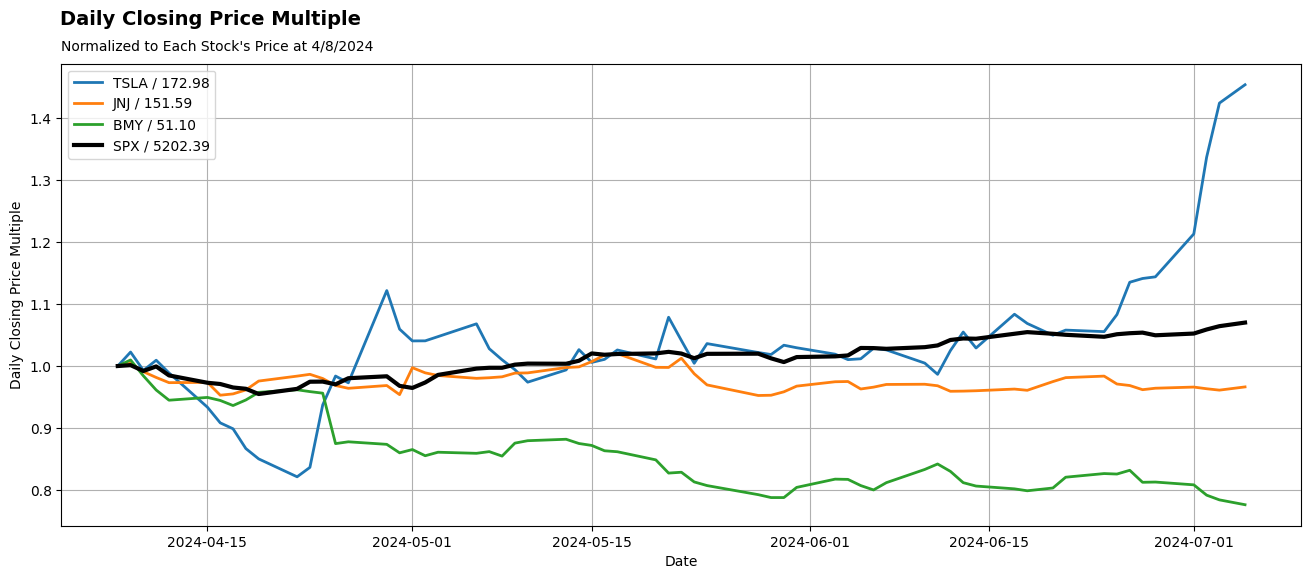

In [9]:
plt.figure(figsize=(16, 6))
for column in list(df.columns[:3]):
    plt.plot(df[column] / df[column][0], lw=2, label=f"{column} / {df[column][0]:.2f}")
column = "SPX"
plt.plot(
    df[column] / df[column][0],
    lw=3,
    color="black",
    label=f"{column} / {df[column][0]:.2f}",
)
plt.grid(True)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily Closing Price Multiple")
plt.title(
    "Normalized to Each Stock's Price at 4/8/2024",
    loc="left",
    fontsize=10,
    pad=10,
)
plt.suptitle(
    "Daily Closing Price Multiple",
    fontsize=14,
    fontweight="bold",
    x=0.124,
    y=0.97,
    ha="left",
)
plt.show()

Insights
- Tesla had a huge rebound starting the last few weeks of June, gaining approximately 50% from its base of $173
- The S&P 500 appreciated about 10% during the last 3 months

# Data Preparation

> The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection, data cleaning, construction of new attributes, and transformation of data for modeling tools.

For one approach, chip up the data into N day segments
- N is a hyperparameter to be searched
- Choose a random stock and starting day, and select N consecutive days
- Target feature is a label of
    - Buy if day N higher than day N - 1
    - Don't buy otherwise
    - Days 1 through N - 2 are training
    - Day N - 1 and N is for evaluation

In [10]:
df.reset_index(inplace=True)
df

,Date,TSLA,JNJ,BMY,LDOS,DOV,CVX,KKR,DGX,STZ,BX,HBAN,A,FDX,MMC,CPB,PM,PWR,XYL,AWK,MGM,RCL,WY,WMB,HAL,HAS,BRO,UNH,VTRS,RVTY,CRL,NTAP,LOW,GL,VICI,EOG,ABT,NDAQ,K,BKNG,IT,BBY,NCLH,CBRE,WFC,EXC,AMGN,MMM,ABNB,MCD,AMZN,SPX
0,2024-04-08,172.98,151.59,51.10,129.24,176.08,161.27,101.65,130.04,266.00,129.32,14.01,144.46,275.57,204.28,43.72,90.32,262.26,127.75,120.02,46.30,138.29,34.42,38.95,40.96,57.59,85.51,456.00,11.75,106.41,254.92,105.82,242.59,107.85,29.63,135.45,110.52,62.14,57.48,3601.17,471.87,80.14,19.39,96.51,57.79,37.78,269.20,91.93,160.27,267.56,185.19,5202.39
1,2024-04-09,176.88,152.29,51.60,127.10,177.35,162.00,100.27,132.75,262.97,132.00,14.04,147.40,276.37,204.33,44.45,91.07,256.40,128.93,121.85,46.41,133.18,35.03,39.24,40.98,57.33,84.56,459.72,11.82,110.72,257.15,104.15,244.39,107.61,29.80,137.06,112.44,63.56,57.12,3581.48,469.89,82.55,19.41,96.20,57.58,37.87,270.36,92.61,162.66,269.44,185.67,5209.91
2,2024-04-10,171.76,150.20,50.29,126.22,173.83,162.67,99.01,131.62,264.92,126.08,13.58,144.16,270.30,201.18,43.68,89.72,254.30,128.19,118.31,44.68,130.90,33.60,38.88,41.11,56.78,83.60,450.05,11.71,107.90,247.49,102.60,237.16,104.93,28.11,137.95,111.17,63.01,57.01,3586.13,463.78,79.89,18.40,91.33,56.94,36.91,266.45,92.63,160.28,268.67,185.95,5160.64
3,2024-04-11,174.60,148.79,49.12,126.64,173.28,161.89,100.45,130.02,268.34,126.87,13.49,145.00,272.18,199.19,43.21,89.43,258.00,128.79,117.82,44.72,133.75,33.65,38.60,40.94,56.23,82.65,441.72,11.57,108.50,246.42,104.86,235.44,49.17,28.20,137.27,111.45,63.06,56.17,3637.87,474.72,80.01,18.63,90.68,56.69,36.80,270.00,93.18,165.42,268.62,189.05,5199.06
4,2024-04-12,171.05,147.52,48.28,125.73,172.06,158.96,97.29,128.53,262.24,123.47,13.31,140.73,267.80,198.07,42.31,88.85,254.69,128.11,116.57,42.48,127.67,33.24,38.08,39.67,55.80,81.90,439.20,11.33,103.49,241.34,101.81,232.05,59.09,27.94,135.29,109.11,61.52,55.42,3531.80,465.45,78.00,17.77,89.39,56.47,36.48,267.28,91.31,159.37,267.39,186.13,5123.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2024-06-28,197.88,146.16,41.53,145.88,180.45,156.42,105.24,136.88,257.28,123.80,13.18,129.63,299.84,210.72,45.19,101.33,254.09,135.63,129.16,44.44,159.43,28.39,42.50,33.78,58.50,89.41,509.26,10.63,104.86,206.58,128.80,220.46,82.28,28.64,125.87,103.91,60.26,57.68,3961.50,449.06,84.29,18.79,89.11,59.39,34.61,312.45,102.19,151.63,254.84,193.25,5460.48
58,2024-07-01,209.86,146.44,41.30,145.56,176.99,156.52,104.51,137.09,256.29,122.23,13.16,127.40,298.68,210.25,45.27,101.25,247.61,131.53,127.76,42.86,156.47,27.56,42.39,33.43,57.52,89.11,494.65,10.59,103.00,203.24,130.24,213.56,82.83,27.90,126.54,103.20,59.48,56.72,3884.88,441.32,82.29,17.68,85.97,60.59,34.55,311.01,100.61,151.63,249.99,197.20,5475.09
59,2024-07-02,231.26,146.03,40.45,145.86,176.96,156.75,105.93,136.64,258.94,123.21,13.21,125.78,298.22,211.99,45.53,101.64,247.78,132.27,128.46,42.33,156.61,27.48,42.30,33.62,57.06,89.65,498.24,10.43,102.01,201.48,129.88,213.70,83.08,27.77,126.65,103.20,59.96,56.70,3916.21,446.12,82.17,17.61,87.08,60.97,34.53,310.77,101.62,154.34,247.79,200.00,5509.01
60,2024-07-03,246.39,145.69,40.06,146.64,176.97,156.71,106.06,140.90,250.37,123.40,13.04,126.13,293.71,212.90,45.01,101.42,254.60,132.71,127.96,43.28,155.38,27.05,42.80,33.78,57.03,90.04,489.89,10.38,102.56,201.42,130.26,213.30,82.44,27.75,126.77,102.33,60.14,56.67,3916.89,447.75,82.33,17.54,87.39,60.66,34.73,309.38,101.62,152.73,250.00,197.59,5537.02


Form the chips

In [11]:
def make_chips(
    df: pd.DataFrame,
    X: pd.DataFrame,
    num_chips: int,
    num_days_per_chip: int,
    seed: int = None,
):
    if seed:
        np.random.seed(seed)
    chips_df = pd.DataFrame()
    while len(chips_df) < num_chips:
        # Choose a random stock and starting date to chip from
        random_start = X.sample(n=1, axis=1).sample(n=1, axis=0)
        stock = random_start.columns[0]
        chip = X.loc[
            random_start.index[0] : random_start.index[0] + num_days_per_chip - 1, stock
        ]
        if len(chip) == num_days_per_chip:
            # Form a mini frame consisting of the chip, plus the date and ticker
            start_date = df["Date"][random_start.index[0]]
            df_chip = pd.DataFrame(
                [[stock, start_date, *chip]],
                columns=["Stock", "Start Date"]
                + ["Day " + str(day + 1) for day in range(num_days_per_chip)],
            )
            # Include the chip in the accumulating frame, and drop duplicates
            chips_df = pd.concat(
                [chips_df, df_chip], ignore_index=True
            ).drop_duplicates()
    return chips_df

In [12]:
num_chips = 500
num_days_per_chip = 7
day_buy = "Day " + str(num_days_per_chip - 1)
day_sell = "Day " + str(num_days_per_chip)
[
    day_buy,
    day_sell,
]

['Day 6', 'Day 7']

In [13]:
chips_df = make_chips(
    df,
    df.drop(columns=["Date", "SPX"]),
    num_chips=num_chips,
    num_days_per_chip=num_days_per_chip,
    seed=13,
)
display(chips_df)

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
0,WFC,2024-06-24,59.01,57.20,57.01,57.42,59.39,60.59,60.97
1,NTAP,2024-05-30,116.50,120.43,118.96,119.00,122.26,121.47,120.98
2,NTAP,2024-05-22,114.11,114.04,115.67,118.01,117.50,116.50,120.43
3,PWR,2024-05-21,272.05,271.10,276.55,283.43,279.64,277.97,279.76
4,MMC,2024-05-16,209.14,209.97,209.16,209.93,210.82,207.99,207.89
...,...,...,...,...,...,...,...,...,...
495,PM,2024-05-06,97.45,97.53,98.25,99.46,99.66,99.29,99.84
496,K,2024-05-01,56.98,61.28,60.51,60.04,61.64,62.33,61.60
497,HAS,2024-06-03,58.67,57.49,58.57,58.39,58.45,58.48,58.39
498,DOV,2024-06-10,177.95,177.27,181.75,181.39,177.25,179.23,182.79


Form the target feature - day N is better than day N - 1

In [14]:
chips_df["Buy"] = chips_df[day_sell] > 1.01 * chips_df[day_buy]
chips_df

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Buy
0,WFC,2024-06-24,59.01,57.20,57.01,57.42,59.39,60.59,60.97,False
1,NTAP,2024-05-30,116.50,120.43,118.96,119.00,122.26,121.47,120.98,False
2,NTAP,2024-05-22,114.11,114.04,115.67,118.01,117.50,116.50,120.43,True
3,PWR,2024-05-21,272.05,271.10,276.55,283.43,279.64,277.97,279.76,False
4,MMC,2024-05-16,209.14,209.97,209.16,209.93,210.82,207.99,207.89,False
...,...,...,...,...,...,...,...,...,...,...
495,PM,2024-05-06,97.45,97.53,98.25,99.46,99.66,99.29,99.84,False
496,K,2024-05-01,56.98,61.28,60.51,60.04,61.64,62.33,61.60,False
497,HAS,2024-06-03,58.67,57.49,58.57,58.39,58.45,58.48,58.39,False
498,DOV,2024-06-10,177.95,177.27,181.75,181.39,177.25,179.23,182.79,True


In [15]:
chips_df["Buy"].value_counts(normalize=True)

Buy
False    0.784
True     0.216
Name: proportion, dtype: float64

# Modeling

> In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques require specific data formats.

Techniques to consider so far
- Time-series regression, such as with sarimax
- Classification
    - Decision Tree
    - Random Forest
    - SVM
    - NN

## Decision Tree and Random Forest Classifiers

### Decision Tree

#### Approach

Fit a classifier, using days 1 through N - 2 as features and the "Buy" column as the target
- So you buy on day N - 1, and sell on day N
- The criterion then is that the day you sell is higher than the day you buy

#### Features

In [143]:
features = ["Day " + str(k) for k in range(1, num_days_per_chip - 1)]
X, y = chips_df[features], chips_df["Buy"]
features

['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']

In [144]:
risk = 100.0  # dollars invested per trade
pl = (chips_df[day_sell] / chips_df[day_buy] - 1.0) * risk
pl.describe()

count    500.000000
mean       0.111025
std        1.790210
min       -7.486034
25%       -0.797327
50%        0.000000
75%        0.804397
max       15.306911
dtype: float64

#### Model

In [145]:
(X_train, X_test, y_train, y_test, pl_train, pl_test) = train_test_split(
    X, y, pl, random_state=42, stratify=y
)

In [146]:
dtc = DecisionTreeClassifier(
    random_state=42,
).fit(X_train, y_train)
[
    dtc.score(X_train, y_train),
    dtc.score(X_test, y_test),
]

[1.0, 0.768]

In [149]:
def ConfusionMatrixPlot(estimator, X, y) -> None:
    ConfusionMatrixDisplay(
        confusion_matrix(y, estimator.predict(X)),
        display_labels=["Don't Buy", "Buy"],
    ).plot()
    plt.grid(False)

In [161]:
confusion_matrix(y_test, dtc.predict(X_test)) == np.array([[88, 10], [19, 8]])

array([[ True,  True],
       [ True,  True]])

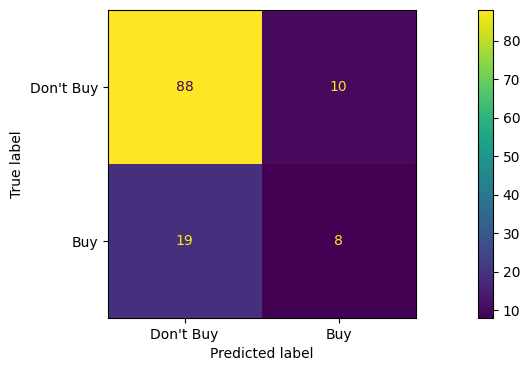

In [150]:
ConfusionMatrixPlot(dtc, X_test, y_test)

In [22]:
def calculate_trading_gain(estimator, X, pl):
    y_pred = np.round(estimator.predict(X)) == 1
    total_gain = round(float(pl[y_pred].sum()), 2)
    return {
        "total risk": y_pred.sum() * risk,
        "total gain": total_gain,
        "number of trading days": len(y_pred),
        "number of trades": y_pred.sum(),
    }

In [23]:
calculate_trading_gain(dtc, X_test, pl_test)

{'total risk': 1800.0,
 'total gain': 7.31,
 'number of trading days': 125,
 'number of trades': 18}

In [24]:
dtc.get_depth()

38

#### Assessment

The initial model is a poor performer
- Although the training accuracy was 100%, the test accuracy was only 77%
     - The 100% training accuracy is indicative of something wrong
     - Notice the tree is 38 deep, which seems quite large
- Worse, the cumulative profit considering 125 trades was only $8
- The model correctly recommended a buy signal just 8 times, compared to 10 incorrect recommendations to buy
     - Meaning it was wrong on the buy side more often than it was right, the accuracy notwithstanding

### Random Forest

#### Approach

Same as decision tree
- But use a random forest for ensemble development
- Use grid search to optimize the forest

#### Model

In [25]:
rfc = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=42).fit(
    X_train, y_train
)
[
    rfc.score(X_train, y_train),
    rfc.score(X_test, y_test),
    rfc.oob_score_,
]

[0.9973333333333333, 0.752, 0.7306666666666667]

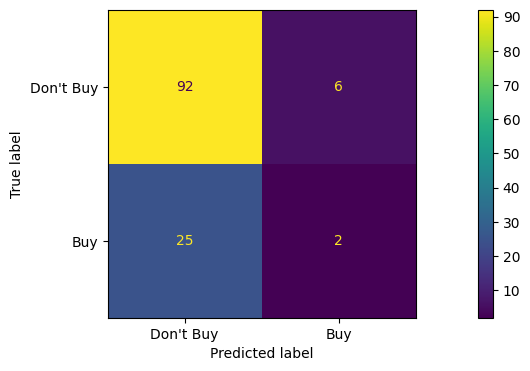

In [26]:
ConfusionMatrixPlot(rfc, X_test, y_test)

In [27]:
calculate_trading_gain(rfc, X_test, pl_test)

{'total risk': 800.0,
 'total gain': 0.11,
 'number of trading days': 125,
 'number of trades': 8}

#### Model with Grid Search

In [28]:
param_grid = {
    "n_estimators": [1, 10, 50, 100],
    "max_features": [3, 5],
    "criterion": ["gini", "log_loss"],
}

In [29]:
grid = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    scoring="balanced_accuracy",
).fit(X_train, y_train)

In [30]:
[
    grid.score(X_train, y_train),
    grid.score(X_test, y_test),
]

[0.8272234819853868, 0.5262660619803476]

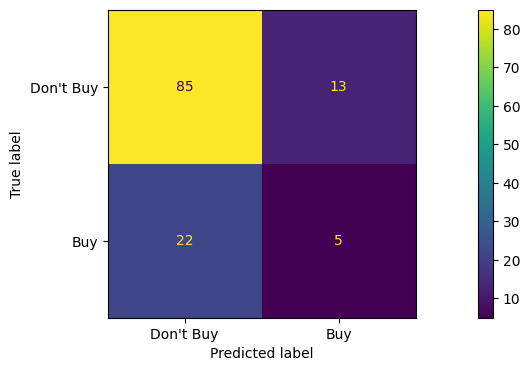

In [31]:
ConfusionMatrixPlot(grid.best_estimator_, X_test, y_test)

In [32]:
grid.best_params_

{'criterion': 'log_loss', 'max_features': 5, 'n_estimators': 1}

In [33]:
calculate_trading_gain(grid.best_estimator_, X_test, pl_test)

{'total risk': 1800.0,
 'total gain': 17.2,
 'number of trading days': 125,
 'number of trades': 18}

#### Assessment

The random forest is also a poor performer

### Random Forest with Derivative of Chips

#### Approach

Use a random forest, but replace feature as raw stock price with feature as first difference of stock price
- d(closing price)/d(1 day)

#### Features

In [34]:
X, y = chips_df[features], chips_df["Buy"]
X = X.diff(axis=1).drop(columns=["Day 1"])
X

,Day 2,Day 3,Day 4,Day 5
0,-1.81,-0.19,0.41,1.97
1,3.93,-1.47,0.04,3.26
2,-0.07,1.63,2.34,-0.51
3,-0.95,5.45,6.88,-3.79
4,0.83,-0.81,0.77,0.89
...,...,...,...,...
495,0.08,0.72,1.21,0.20
496,4.30,-0.77,-0.47,1.60
497,-1.18,1.08,-0.18,0.06
498,-0.68,4.48,-0.36,-4.14


#### Model

In [35]:
(X_train, X_test, y_train, y_test, pl_train, pl_test) = train_test_split(
    X, y, pl, random_state=42, stratify=y
)

In [36]:
rfc = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=42).fit(
    X_train, y_train
)
[
    rfc.score(X_train, y_train),
    rfc.score(X_test, y_test),
    rfc.oob_score_,
]

[0.9973333333333333, 0.776, 0.7386666666666667]

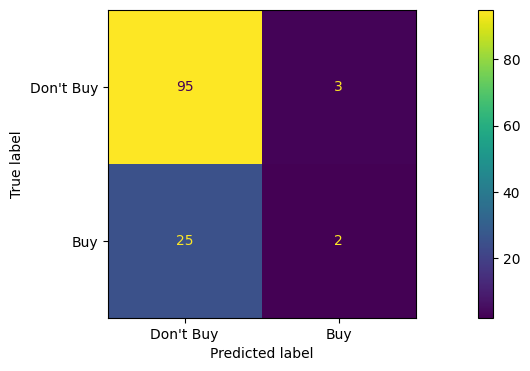

In [37]:
ConfusionMatrixPlot(rfc, X_test, y_test)

In [38]:
calculate_trading_gain(rfc, X_test, pl_test)

{'total risk': 500.0,
 'total gain': 3.68,
 'number of trading days': 125,
 'number of trades': 5}

### Decision Tree - all Stocks

#### Approach

As the above decision tree, but rather than picking single stocks, pick the entire market, represented by the S&P 500

#### Features

Form another chip dataframe, from just the S&P 500
- Have to use a lower chip count, since the overall data set is now much smaller

In [39]:
sp500_chips_df = make_chips(
    df,
    df[["SPX"]],
    num_chips=50,
    num_days_per_chip=num_days_per_chip,
    seed=13,
)
sp500_chips_df.head()

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
0,SPX,2024-06-26,5477.90,5482.87,5460.48,5475.09,5509.01,5537.02,5567.19
1,SPX,2024-06-24,5447.87,5469.30,5477.90,5482.87,5460.48,5475.09,5509.01
2,SPX,2024-06-11,5375.32,5421.03,5433.74,5431.60,5473.23,5487.03,5473.17
3,SPX,2024-05-02,5064.20,5127.79,5180.74,5187.70,5187.67,5214.08,5222.68
4,SPX,2024-06-04,5291.34,5354.03,5352.96,5346.99,5360.79,5375.32,5421.03


Buy signal - market rose at least 1/2%

In [40]:
sp500_chips_df["Buy"] = sp500_chips_df[day_sell] > 1.005 * sp500_chips_df[day_buy]
sp500_chips_df.head()

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Buy
0,SPX,2024-06-26,5477.90,5482.87,5460.48,5475.09,5509.01,5537.02,5567.19,True
1,SPX,2024-06-24,5447.87,5469.30,5477.90,5482.87,5460.48,5475.09,5509.01,True
2,SPX,2024-06-11,5375.32,5421.03,5433.74,5431.60,5473.23,5487.03,5473.17,False
3,SPX,2024-05-02,5064.20,5127.79,5180.74,5187.70,5187.67,5214.08,5222.68,False
4,SPX,2024-06-04,5291.34,5354.03,5352.96,5346.99,5360.79,5375.32,5421.03,True


The class is pretty imbalanced - 70% of the time, no buy

In [41]:
sp500_chips_df["Buy"].value_counts(normalize=True)

Buy
False    0.7
True     0.3
Name: proportion, dtype: float64

In [42]:
X, y = sp500_chips_df[features], sp500_chips_df["Buy"]
features

['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']

In [43]:
sp500_pl = (sp500_chips_df[day_sell] / sp500_chips_df[day_buy] - 1.0) * risk
sp500_pl.describe()

count    50.000000
mean      0.211089
std       0.547038
min      -0.875852
25%      -0.193297
50%       0.161090
75%       0.535931
max       1.255677
dtype: float64

#### Model

In [44]:
(X_train, X_test, y_train, y_test, sp500_pl_train, sp500_pl_test) = train_test_split(
    X,
    y,
    sp500_pl,
    random_state=42,
    stratify=y,
    test_size=0.5,
)

In [45]:
dtc = DecisionTreeClassifier(
    random_state=42,
).fit(X_train, y_train)
[
    dtc.score(X_train, y_train),
    dtc.score(X_test, y_test),
]

[1.0, 0.52]

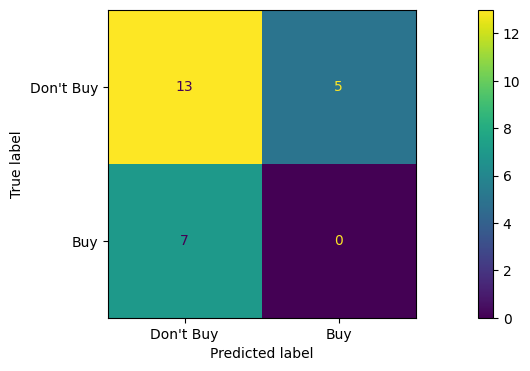

In [46]:
ConfusionMatrixPlot(dtc, X_test, y_test)

In [47]:
calculate_trading_gain(dtc, X_test, sp500_pl_test)

{'total risk': 500.0,
 'total gain': -1.17,
 'number of trading days': 25,
 'number of trades': 5}

#### Assessment

This data set is far too limited
- After allowing even 40% to the test set, there were only a total of 7 buy signals
- And the model got all but 1 of those wrong on the test set, recommending not to buy
- As before, the model was 100% accurate on the training set though

### Decision Tree - all Stocks with more data

#### Approach

Repeat the total market search, but use 3 years of data, not 3 months

#### Data Load

In [48]:
df_sp500_3_years = read_stock_csv(stock="SPX", filename="./data/SPX_3_years.csv")[::-1]
df_sp500_3_years["SPX"] = df_sp500_3_years["SPX"].str.replace(",", "").apply(float)
df_sp500_3_years

,SPX
Date,
2021-07-12,4384.63
2021-07-13,4369.21
2021-07-14,4374.30
2021-07-15,4360.03
2021-07-16,4327.16
...,...
2024-07-08,5572.85
2024-07-09,5576.98
2024-07-10,5633.91


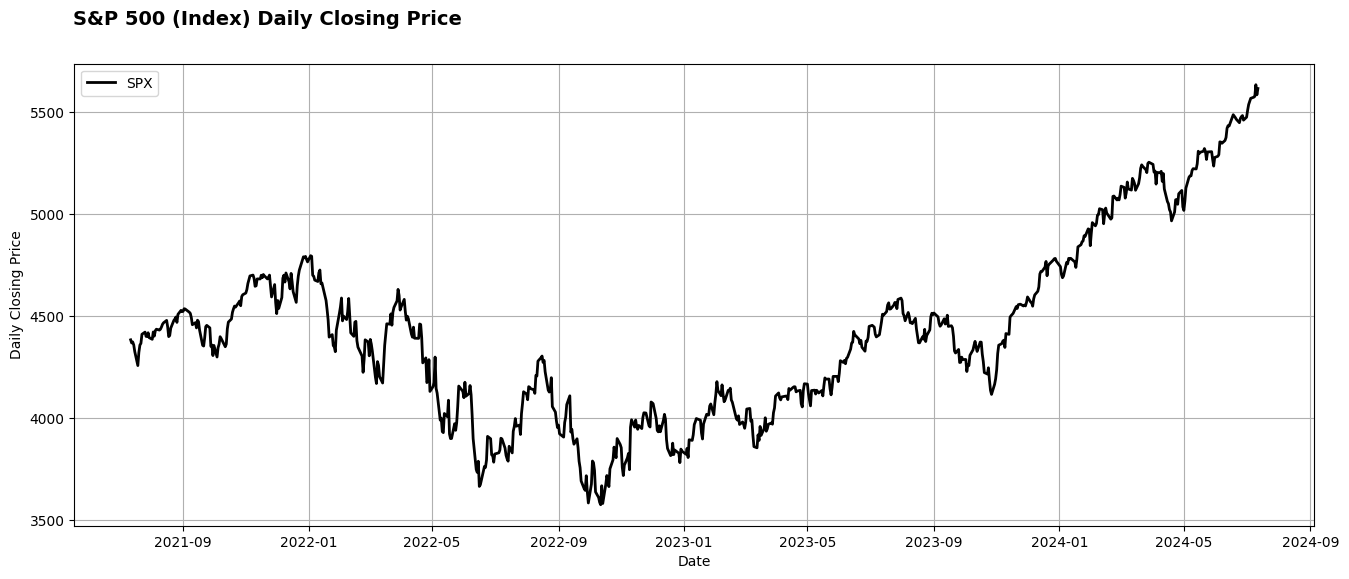

In [49]:
plt.figure(figsize=(16, 6))
column = "SPX"
plt.plot(
    df_sp500_3_years[column],
    lw=2,
    color="black",
    label=column,
)
plt.grid(True)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily Closing Price")
plt.suptitle(
    "S&P 500 (Index) Daily Closing Price",
    fontsize=14,
    fontweight="bold",
    x=0.124,
    y=0.97,
    ha="left",
)
plt.show()

#### Features

In [50]:
df_sp500_3_years.reset_index(inplace=True)
df_sp500_3_years

,Date,SPX
0,2021-07-12,4384.63
1,2021-07-13,4369.21
2,2021-07-14,4374.30
3,2021-07-15,4360.03
4,2021-07-16,4327.16
...,...,...
751,2024-07-08,5572.85
752,2024-07-09,5576.98
753,2024-07-10,5633.91
754,2024-07-11,5584.54


In [51]:
sp500_chips_df = make_chips(
    df_sp500_3_years,
    df_sp500_3_years[["SPX"]],
    num_chips=500,
    num_days_per_chip=num_days_per_chip,
    seed=13,
)
sp500_chips_df.head()

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
0,SPX,2021-12-21,4649.23,4696.56,4725.79,4791.19,4786.35,4793.06,4778.73
1,SPX,2022-03-17,4411.67,4463.12,4461.18,4511.61,4456.24,4520.16,4543.06
2,SPX,2022-12-05,3998.84,3941.26,3933.92,3963.51,3934.38,3990.56,4019.65
3,SPX,2023-12-07,4585.59,4604.37,4622.44,4643.70,4707.09,4719.55,4719.19
4,SPX,2023-08-02,4513.39,4501.89,4478.03,4518.44,4499.38,4467.71,4468.83


Buy signal - market rose at least 1/2%

In [52]:
sp500_chips_df["Buy"] = sp500_chips_df[day_sell] > 1.005 * sp500_chips_df[day_buy]
sp500_chips_df.head()

,Stock,Start Date,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Buy
0,SPX,2021-12-21,4649.23,4696.56,4725.79,4791.19,4786.35,4793.06,4778.73,False
1,SPX,2022-03-17,4411.67,4463.12,4461.18,4511.61,4456.24,4520.16,4543.06,True
2,SPX,2022-12-05,3998.84,3941.26,3933.92,3963.51,3934.38,3990.56,4019.65,True
3,SPX,2023-12-07,4585.59,4604.37,4622.44,4643.70,4707.09,4719.55,4719.19,False
4,SPX,2023-08-02,4513.39,4501.89,4478.03,4518.44,4499.38,4467.71,4468.83,False


The class is pretty imbalanced - 70% of the time, no buy

In [53]:
sp500_chips_df["Buy"].value_counts(normalize=True)

Buy
False    0.688
True     0.312
Name: proportion, dtype: float64

In [54]:
X, y = sp500_chips_df[features], sp500_chips_df["Buy"]
features

['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']

In [55]:
sp500_pl = (sp500_chips_df[day_sell] / sp500_chips_df[day_buy] - 1.0) * risk
sp500_pl.describe()

count    500.000000
mean       0.067725
std        1.090358
min       -4.323656
25%       -0.579388
50%        0.073615
75%        0.717516
max        5.543447
dtype: float64

#### Model

In [56]:
(X_train, X_test, y_train, y_test, sp500_pl_train, sp500_pl_test) = train_test_split(
    X,
    y,
    sp500_pl,
    random_state=42,
    stratify=y,
    test_size=0.5,
)

In [57]:
dtc = DecisionTreeClassifier(
    random_state=42,
).fit(X_train, y_train)
[
    dtc.score(X_train, y_train),
    dtc.score(X_test, y_test),
]

[1.0, 0.584]

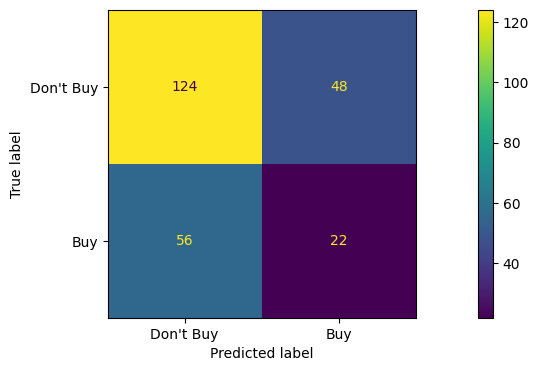

In [58]:
ConfusionMatrixPlot(dtc, X_test, y_test)

In [59]:
calculate_trading_gain(dtc, X_test, sp500_pl_test)

{'total risk': 7000.0,
 'total gain': 6.36,
 'number of trading days': 250,
 'number of trades': 70}

#### Assessment

Using a larger data set allowed for a non-trivial number of buy signals
- The model continues to be 100% accurate on the training set
- But is wrong on the buy signal more than twice as often as it is right

### Random Forest with Derivative of Chips - all Stocks

#### Approach

Use the first difference of the total market

#### Features

In [60]:
X, y = sp500_chips_df[features], sp500_chips_df["Buy"]
X = X.diff(axis=1).drop(columns=["Day 1"])
X.head()

,Day 2,Day 3,Day 4,Day 5
0,47.33,29.23,65.40,-4.84
1,51.45,-1.94,50.43,-55.37
2,-57.58,-7.34,29.59,-29.13
3,18.78,18.07,21.26,63.39
4,-11.50,-23.86,40.41,-19.06


#### Model

In [61]:
(X_train, X_test, y_train, y_test, sp500_pl_train, sp500_pl_test) = train_test_split(
    X, y, sp500_pl, random_state=42, stratify=y
)

In [62]:
rfc = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=42).fit(
    X_train, y_train
)
[
    rfc.score(X_train, y_train),
    rfc.score(X_test, y_test),
    rfc.oob_score_,
]

[1.0, 0.624, 0.656]

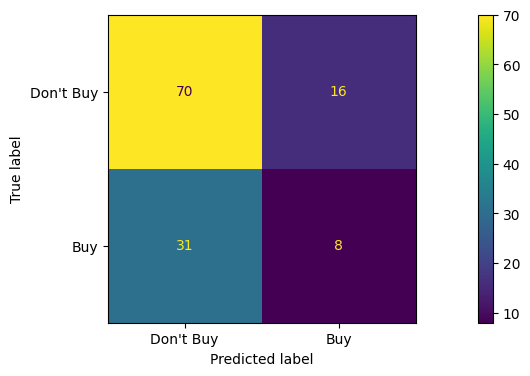

In [63]:
ConfusionMatrixPlot(rfc, X_test, y_test)

In [64]:
calculate_trading_gain(rfc, X_test, sp500_pl_test)

{'total risk': 2400.0,
 'total gain': 6.0,
 'number of trading days': 125,
 'number of trades': 24}

#### Assessment

The derivative of the chip data performed no better
- Conclusion is that decision trees and random forests are generally poor for this problem
- Time to rethink the problem formulation

## Neural Network Models

The above modeling showed that decision trees and random forests were generally poor performers and perhaps ill suited for the problem, so it's time to rethink the problem
- Consider an RNN or LSTM
- Continue to think of the data in chips, which are fed into the RNN
- Rather than a classifier looking at the difference between k + 2 and k + 1 pricing
    - Look at a regressor, with the target feature being the difference of closing and opening price on k + 1
    - where k is the last day of the training chip and k + m is m days lookahead

### Data Source and Preparation

Use the 3-year S&P500 data from above
- Instead of random chips, form overlapped windows
- Instead of the raw price, look consider the difference between closing and opening price
- Assume that market orders can be filled near these prices
    - Then choose to buy if close/open spread is positive

Load the data

In [65]:
sp500_df = (
    pd.read_csv("./data/SPX_3_years.csv")[::-1]
    .reset_index(drop=True)
    .drop(columns=["Date", "High", "Low"])
)
sp500_df

,Open,Close
0,"4,372.41","4,384.63"
1,"4,381.07","4,369.21"
2,"4,380.11","4,374.30"
3,"4,369.02","4,360.03"
4,"4,367.43","4,327.16"
...,...,...
751,"5,572.75","5,572.85"
752,"5,584.24","5,576.98"
753,"5,591.26","5,633.91"
754,"5,635.21","5,584.54"


String -> Float conversion

In [66]:
for col in sp500_df.columns:
    sp500_df[col] = sp500_df[col].str.replace(",", "").apply(float)
sp500_df

,Open,Close
0,4372.41,4384.63
1,4381.07,4369.21
2,4380.11,4374.30
3,4369.02,4360.03
4,4367.43,4327.16
...,...,...
751,5572.75,5572.85
752,5584.24,5576.98
753,5591.26,5633.91
754,5635.21,5584.54


Form the target feature: spread between open and closing prices
- Normalize by the opening price
- Then multiply by the risk
- So we are getting actual dollars per trade if risking risk per trade

In [67]:
data = (
    (sp500_df["Close"] - sp500_df["Open"]) / sp500_df["Open"] * risk
).values.reshape(-1, 1)

In [68]:
data = (sp500_df["Close"]).values.reshape(-1, 1)

In [69]:
frac_train = 0.8
n_train = int(frac_train * data.shape[0])
n_train

604

In [70]:
# Normalize the data - use only the training portion for fitting the scaler
data_to_fit = np.log(data.copy())
mm = MinMaxScaler().fit(data_to_fit[:n_train])
data_mm = mm.transform(data_to_fit).reshape(
    -1,
)
data_mm.shape

(756,)

In [71]:
unscale = lambda x: np.exp(mm.inverse_transform(x.reshape(-1, 1)))

In [72]:
unscale(mm.transform(np.log(np.array([2, 3, 4])).reshape(-1, 1)))

array([[2.],
       [3.],
       [4.]])

Chunk the data into overlapped windows of **history** days of training and **forecast** days of forecast

In [73]:
# enable this for checking the splits are doing as intended
# data_mm = np.array(list(range(num_days_per_chip * 5)))

In [74]:
def build_window(data, history, forecast):
    # Chunk the data into overlapped windows of history days of training and forecast days of forecast
    dataX, dataY = [], []
    for i in range(len(data) - history - forecast):
        dataX.append(data[i : (i + history)])
        dataY.append(data[(i + history) : (i + history + forecast)])
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    return dataX, dataY

In [75]:
num_days_train, num_days_forecast = num_days_per_chip - 1, 1
data_X, data_Y = build_window(
    data_mm, history=num_days_train, forecast=num_days_forecast
)
[
    data_X.shape,
    data_Y.shape,
]

[(749, 6), (749, 1)]

In [119]:
X_train, y_train = data_X[:n_train, :], data_Y[:n_train]
X_test, y_test = data_X[n_train:, :], data_Y[n_train:]
[
    X_train.shape,
    y_train.shape,
    X_test.shape,
    y_test.shape,
]

[(604, 6), (604, 1), (145, 6), (145, 1)]

### Plot Helpers

In [77]:
def plot_rmse(history: dict, model_name: str) -> None:
    plt.plot(np.sqrt(history.history["mse"]), label="Training RMSE")
    plt.plot(np.sqrt(history.history["val_mse"]), label="Test RMSE")
    plt.xlabel("Epochs")
    plt.ylabel("Root Mean Squared Error")
    plt.legend()
    plt.title(f"RMSE vs. Epoch: {model_name}")
    plt.grid(True)

In [78]:
def plot_actuals(model, X_train, X_test, y_train, y_test, model_name: str) -> None:
    y = unscale(np.concatenate([y_train, y_test]))
    yhat = unscale(np.concatenate([model.predict(X_train), model.predict(X_test)]))

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(y, label="Target Feature", color="black")
    ax.plot(
        yhat,
        label="Prediction of Target Feature",
        color="blue",
    )
    ax.vlines(
        x=len(y_train),
        ymin=y.min(),
        ymax=y.max(),
        color="cyan",
        label="Train/Test Partition",
        lw=2,
    )
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("S&P 500 Price (USD)")
    plt.title(f"Actual and Predicted Price: {model_name}")
    plt.grid(True)

    fig, ax = plt.subplots(figsize=(16, 6))
    err = (y - yhat) / y * 100.0
    ax.plot(err, label="Error", color="black")
    ax.vlines(
        x=len(y_train),
        ymin=err.min(),
        ymax=err.max(),
        color="cyan",
        label="Train/Test Partition",
        lw=2,
    )
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Prediction Error (% of Predicted)")
    plt.title(
        f"Prediction Error Percentage: {model_name}\nAverage Test Error = {err[len(y_train):].mean():.2f}%"
    )
    plt.grid(True)

### Simple NN

#### Approach

Form a baseline with a single dense layer and 1 regression output layer
- A dense layer with relu
- An output layer with 1 neuron and no activation

In [93]:
def reseed(seed: int = 41):
    """
    For getting fully repeatable tensorflow runs
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

#### Model

In [99]:
reseed()
nn_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(num_days_forecast),
    ]
)
nn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"])
nn_history = nn_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=25,
    verbose=0,
    validation_data=(X_test, y_test),
)

In [100]:
nn_history.history["mse"][:5]

[1.5288777351379395,
 0.9367755651473999,
 0.5346499085426331,
 0.2582342028617859,
 0.10183218866586685]

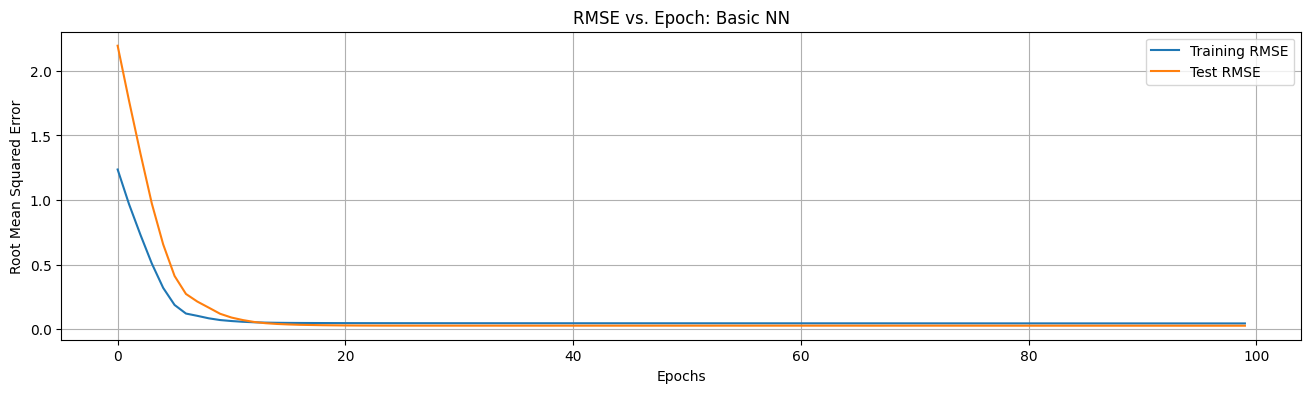

In [101]:
plot_rmse(nn_history, model_name="Basic NN")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


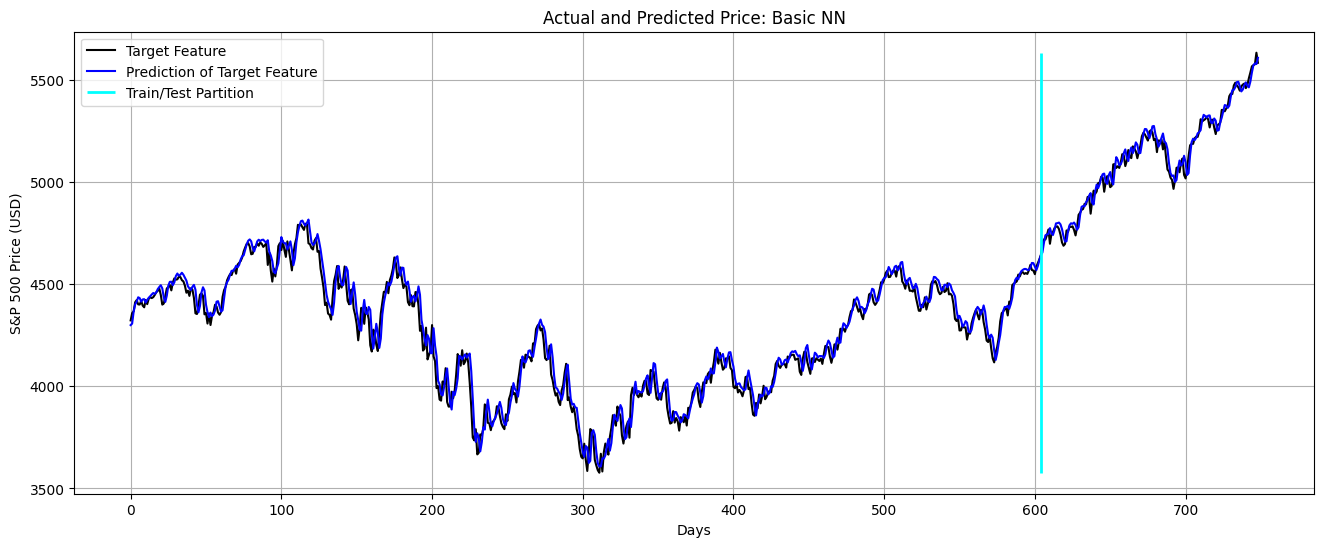

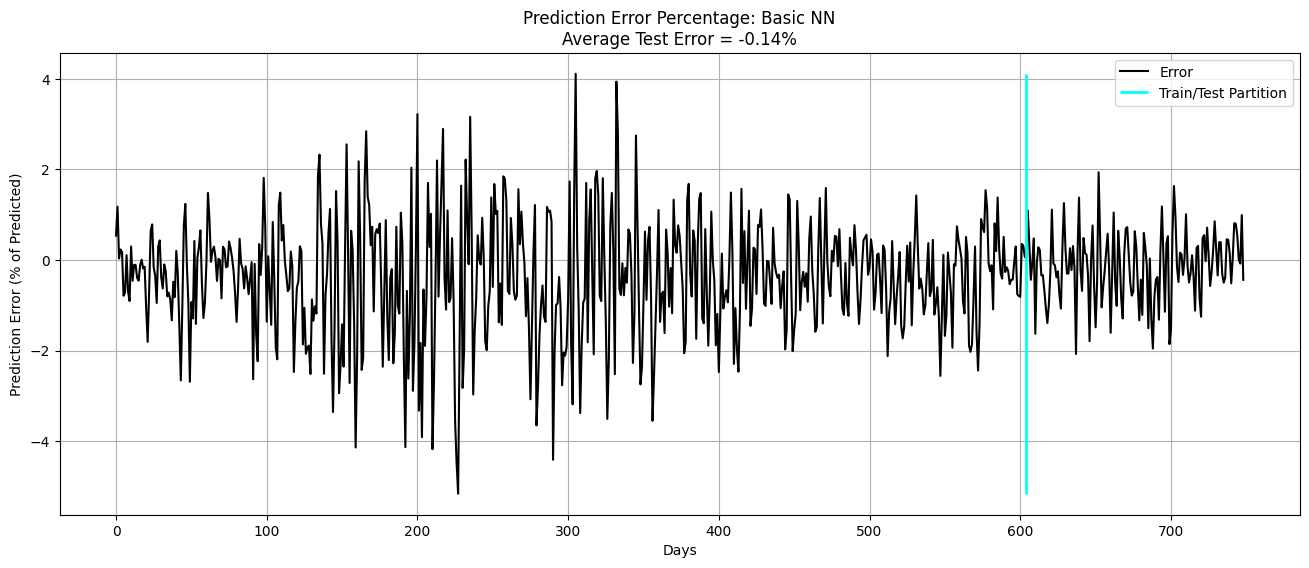

In [102]:
plot_actuals(nn_model, X_train, X_test, y_train, y_test, model_name="Basic NN")

In [142]:
def buy_signal(y):
    """
    Buy if first difference is positive
    Assumes you can get the day before's closing price at the market open
    """
    return (y[1:] - y[:-1]) > 0.0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


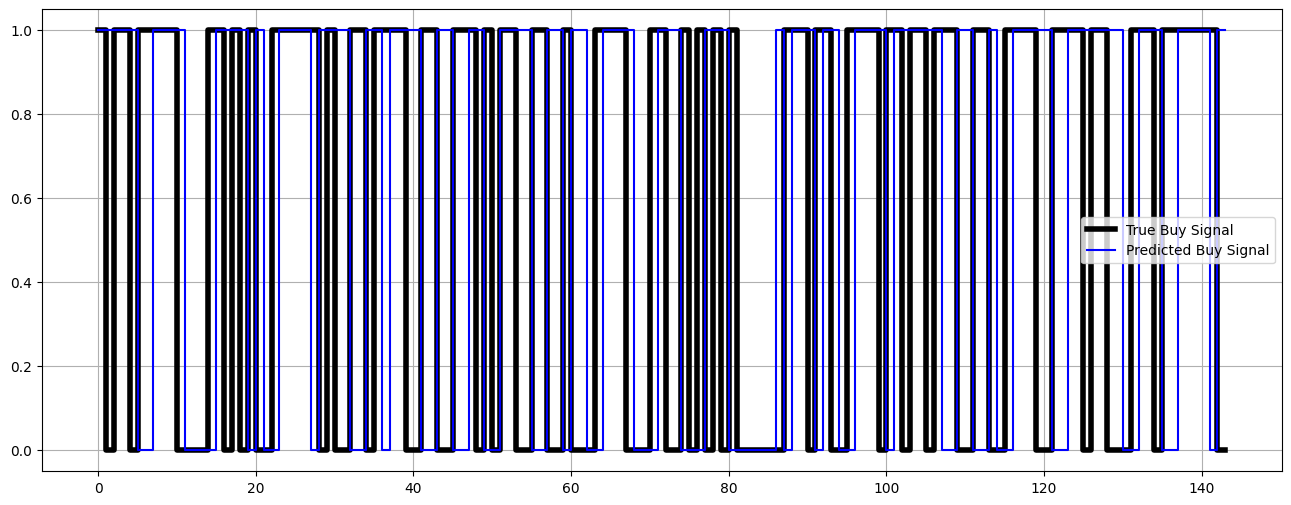

In [140]:
y_test_unscaled = unscale(y_test)
yhat_test_unscaled = unscale(nn_model.predict(X_test))
plt.figure(figsize=(16, 6))
plt.step(
    range(len(y_test_unscaled) - 1),
    buy_signal(y_test_unscaled),
    color="black",
    lw=4,
    label="True Buy Signal",
)
plt.step(
    range(len(yhat_test_unscaled) - 1),
    buy_signal(yhat_test_unscaled),
    color="blue",
    label="Predicted Buy Signal",
)
plt.legend()
plt.grid(True)

#### Assessment

The basic NN performance is very poor, registering errors of up to 5 percentage points per day
- But the average error in test was less than 0.25%

### RNN

#### Approach

Use an RNN to capture the ordering relationship

In [84]:
# Reshape the data to prepare for RNN
def insert_singleton(X):
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))


X_train_reshaped = insert_singleton(X_train)
X_test_reshaped = insert_singleton(X_test)
[
    X_train_reshaped.shape,
    X_test_reshaped.shape,
]

[(604, 1, 6), (145, 1, 6)]

#### Model

In [85]:
reseed()
rnn_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(
            16, input_shape=(1, num_days_train), return_sequences=True
        ),
        tf.keras.layers.Dense(num_days_forecast),
    ]
)
rnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"])
rnn_history = rnn_model.fit(
    X_train_reshaped,
    y_train,
    epochs=100,
    batch_size=10,
    verbose=0,
    validation_data=(X_test_reshaped, y_test),
)

In [86]:
rnn_history.history["mse"][:5]

[0.1939661204814911,
 0.007621718570590019,
 0.0034950249828398228,
 0.0028467632364481688,
 0.002694661496207118]

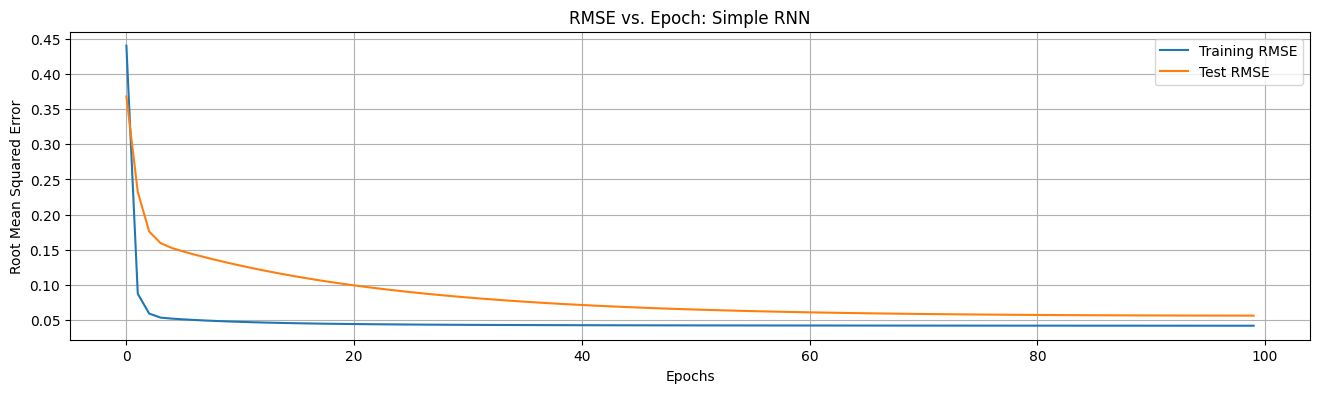

In [87]:
plot_rmse(rnn_history, model_name="Simple RNN")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


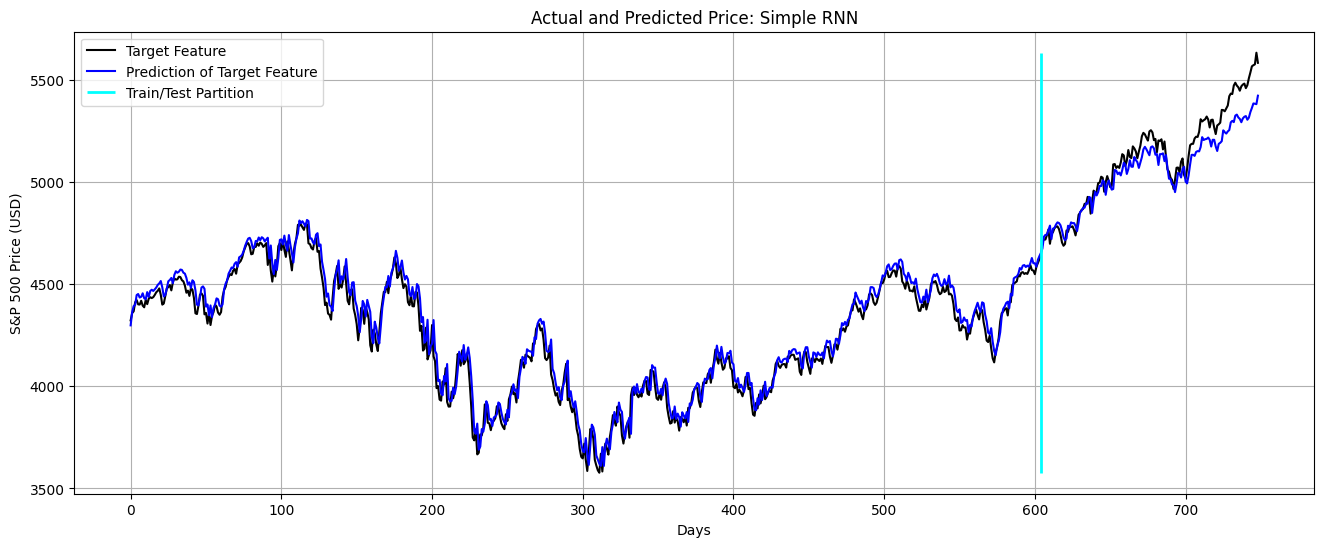

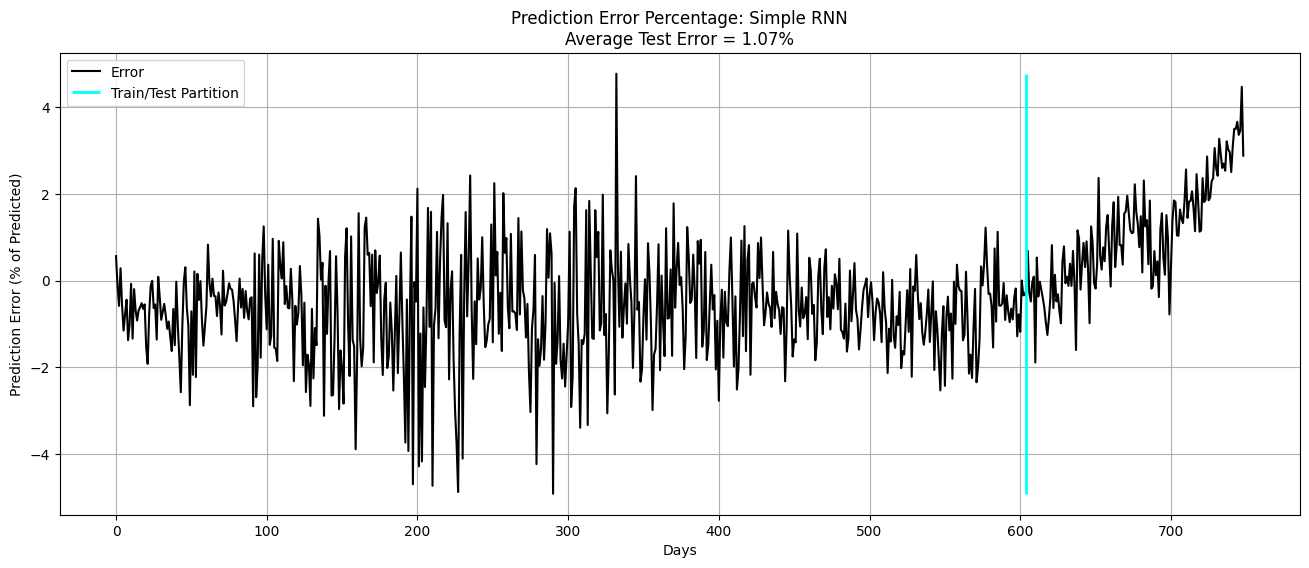

In [88]:
plot_actuals(
    rnn_model,
    X_train_reshaped,
    X_test_reshaped,
    y_train,
    y_test,
    model_name="Simple RNN",
)

#### Assessment

The RNN is worse than the basic NN in the latter part of the prediction timeline

### LSTM

#### Approach

Use an LSTM to capture the ordering relationship

#### Model

In [89]:
reseed()
lstm_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(
            16,
            input_shape=(1, num_days_train),
            activation="exponential",
            return_sequences=True,
        ),
        tf.keras.layers.Dense(num_days_forecast),
    ]
)
lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"])
lstm_history = lstm_model.fit(
    X_train_reshaped,
    y_train,
    epochs=100,
    batch_size=5,
    verbose=0,
    validation_data=(X_test_reshaped, y_test),
)

In [90]:
[
    np.sqrt(lstm_history.history["mse"][-5:]),
    np.sqrt(lstm_history.history["val_mse"][-5:]),
]

[array([0.04389963, 0.04388779, 0.0438761 , 0.04386456, 0.04385318]),
 array([0.0462545 , 0.04644659, 0.04663908, 0.04683208, 0.04702494])]

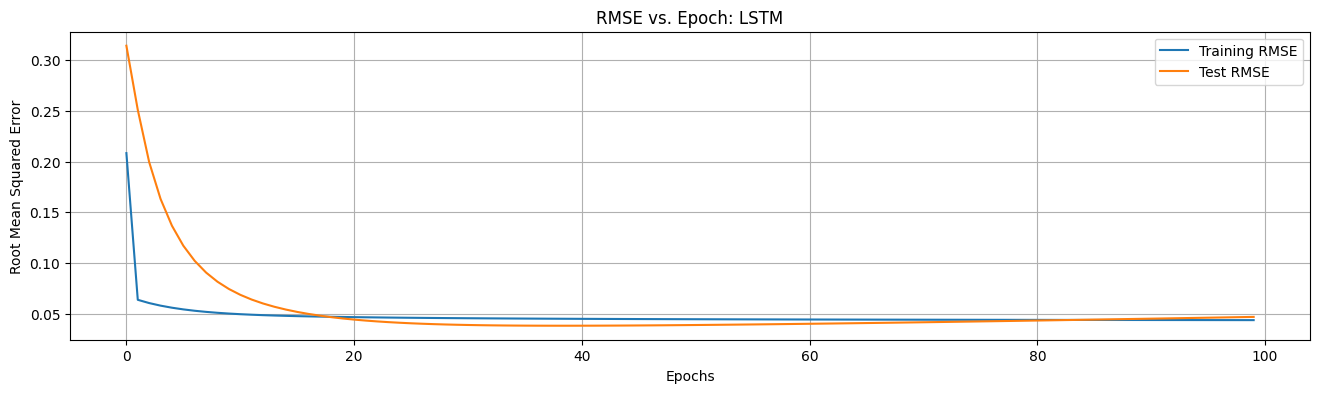

In [91]:
plot_rmse(lstm_history, model_name="LSTM")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


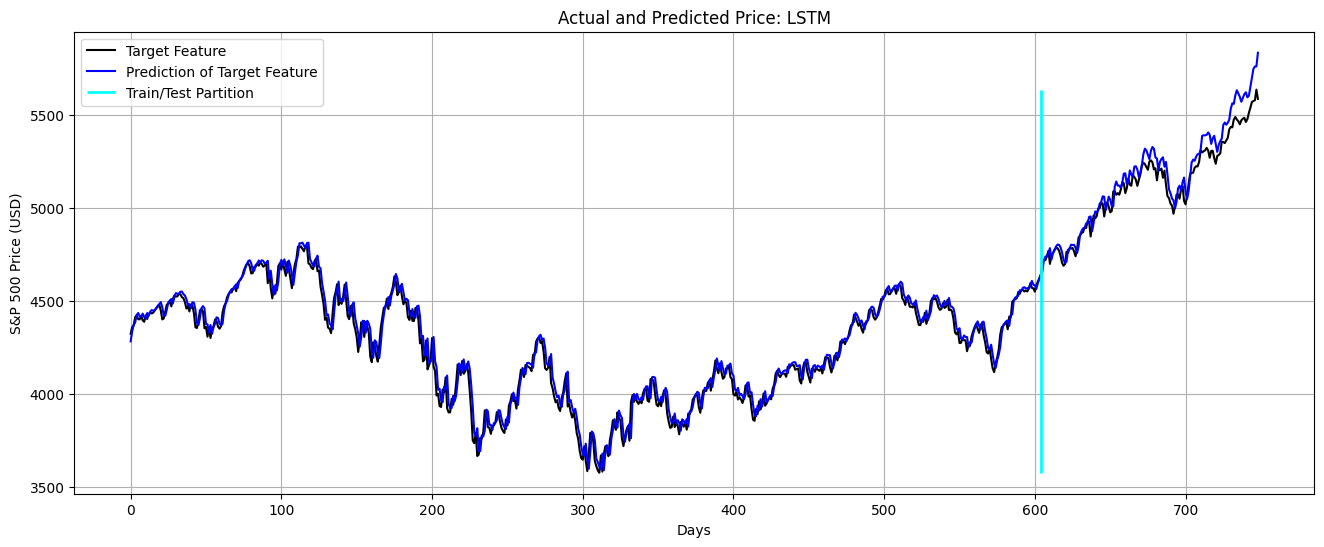

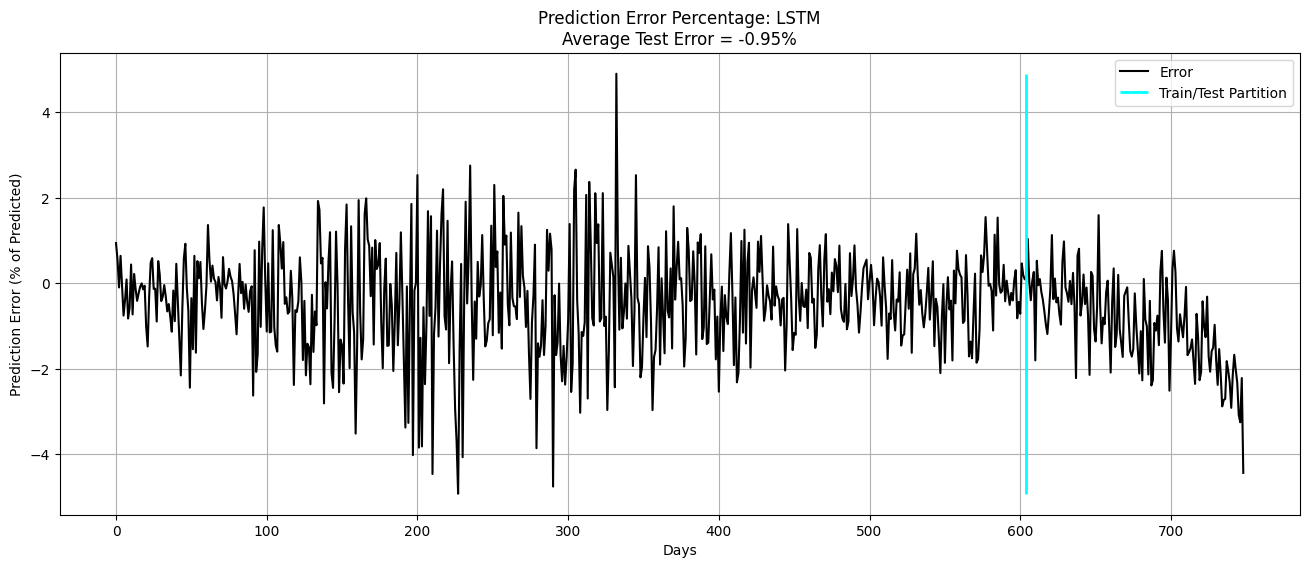

In [92]:
plot_actuals(
    lstm_model,
    X_train_reshaped,
    X_test_reshaped,
    y_train,
    y_test,
    model_name="LSTM",
)

#### Assessment

The LSTM is not looking any better than the RNN or NN
- An exponential activation function was used, which switched the slope error of the in the test set from positive (NN and RNN) to negative
- But the average error was still worse than the NN

# Evaluation

> At this stage in the project you have built one or more models that appear to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.

# Deployment

> Creation of the model is generally not the end of the project. Usually, the knowledge gained will need to be organized and presented in a way that the customer can use it. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining process. In many cases it will be the user, not the data analyst, who will carry out the deployment steps. In any case, it is important to understand up front what actions will need to be carried out in order to actually make use of the created models.